In [1]:
#set up

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from fredapi import Fred
from math import sqrt
import matplotlib.pyplot as plt

C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# Part 1
# import Excel file 

df  = pd.read_excel('NS.xlsx', sheet_name='shocks')

In [3]:
# renaming NS columns for clarity

df = df.rename(columns={'fomc':'date'})
df = df.rename(columns={'ff.shock.0':'ff'})
df = df.rename(columns={'ns.shock':'ns'})

In [4]:
df

,date,ff,ns
0,2000-02-02,-0.053704,0.008888
1,2000-03-21,-0.031000,0.005451
2,2000-05-16,0.041333,0.042655
3,2000-06-28,-0.030000,-0.016365
4,2000-08-22,0.000000,0.019035
...,...,...,...
146,2019-03-20,0.000000,-0.022119
147,2019-05-01,-0.025833,-0.025557
148,2019-06-19,0.061364,-0.051041
149,2019-07-31,0.037500,0.038828


In [5]:
# converting date to y-m format

df['date'] = df.date.dt.to_period("M")

In [6]:
df

,date,ff,ns
0,2000-02,-0.053704,0.008888
1,2000-03,-0.031000,0.005451
2,2000-05,0.041333,0.042655
3,2000-06,-0.030000,-0.016365
4,2000-08,0.000000,0.019035
...,...,...,...
146,2019-03,0.000000,-0.022119
147,2019-05,-0.025833,-0.025557
148,2019-06,0.061364,-0.051041
149,2019-07,0.037500,0.038828


In [7]:
# 2. FRED

# connecting to FRED API
fred = Fred(api_key='0e929d96cfbf2133c9a346a74670f033')

# gathering fred data (currently as series)
data1 = fred.get_series('INDPRO')
data2 = fred.get_series('CPIAUCSL')
data3 = fred.get_series('UNRATE')

In [8]:
data3

1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
             ... 
2022-06-01    3.6
2022-07-01    3.5
2022-08-01    3.7
2022-09-01    3.5
2022-10-01    3.7
Length: 898, dtype: float64

In [9]:
# convering series into DataFrame
# TODO: <name of df> = pd.DataFrame({'<1st col name>':<series>, })
d1 = pd.DataFrame({'date':data1.index, 'INDPRO':data1.values})
d2 = pd.DataFrame({'date':data2.index, 'CPIAUCSL':data2.values})
d3 = pd.DataFrame({'date':data3.index, 'UNRATE':data3.values})

In [10]:
# converting date to y-m format

d1['date'] = d1.date.dt.to_period("M")
d2['date'] = d2.date.dt.to_period("M")
d3['date'] = d3.date.dt.to_period("M")

In [11]:
# MERGING!
# d1 is the oldest so we will merge on it (left merge)

merged = pd.merge(d1, d2, how="left", on="date")
merged = pd.merge(merged, d3, how="left", on="date")
merged = pd.merge(merged, df, how="left", on="date")

In [12]:
# creating an observed row

merged['Observed'] = 0

# switiching all NaN values to 0's 

merged.ff = merged.ff.fillna(0)
merged.ns = merged.ns.fillna(0)

# if there was a shock for a particular month we set observed equal to 1

merged.loc[  ~(merged['ff'] == 0) | ~(merged['ns'] == 0) ,'Observed'] ='1'

#replacing 0's to NaN
# merged = merged['Observed'].replace(0, np.nan)

merged.loc[merged['Observed'] == 0,'Observed'] = np.nan
                

In [13]:
# creating a cumsum for both ff ans ns

# merged['ff.cumsum'] = merged['ff'].cumsum()
# merged['ns.cumsum'] = merged['ns'].cumsum()

In [14]:
# rearranging the dataframe for clarity

merged = merged[['date', 'Observed', 'INDPRO', 'CPIAUCSL', 'UNRATE', 'ff', 'ns']]

In [15]:
# part 3

# *Retail and food services sales, total; RSAFS
# *Retail sales, total; RSXFS 
# *Retail sales, total (excl. motor vehicle and parts dealers); 

# all of the four digit NAICS codes ----
# *Automotive parts, acc., and tire stores
# Building mat. and supplies dealers
# Grocery stores
# Beer, wine and liquor stores
# Clothing stores
# Shoe stores
# Department stores
# Other general merchandise stores
# Electronic shopping and mail order houses

In [16]:
# the super awesome functions that will do part 3 for us


def part3(naics_codes, master_df):
    
    for each in naics_codes:
        if len(str(each)) == 4:
            full_code = "MRTSSM"
            full_code += str(each)
            full_code += "USS"
        else:
            full_code = each

        # make call to FRED API
        temp_df = fred.get_series(full_code)

        # change series to dataframe
        temp_df = pd.DataFrame({'date':temp_df.index, str(each):temp_df.values})

        # convert dates as strings to dates as dateTime64[ns]
        temp_df['date'] = pd.to_datetime(temp_df['date'], format='%b. %Y')

        # converting date to y-m format
        temp_df['date'] = temp_df.date.dt.to_period("M")
        
        # merge the data to master_df
        master_df = pd.merge(master_df, temp_df, how="left", on="date")
    
    return master_df

# get the fredList
# the only thing I could think of doing is getting all of the codes from the xlsx file census

# I am going to read that in, get all of the 4 digit codes, then add retail, retail excl dealers, etc.
# as those do not conform to the regular fred syntax (MRTSSM****USS)


def getFredList():
    # reading in excel file
    # NOTE: converted census xls file to xlsx file for consistancy
    # skipping these rows when reading in excel file -- they are white space or c
    skipr= list(range(0,77))
    skipr2= list(range(110, 122))
    skipr.extend(skipr2)
    dfc = pd.read_excel('censusData.xlsx', header= [0,1], skiprows= skipr)
    
    # renaming columns for clarity
    dfc.columns = ['NAICS Code', 'Kind of Business', 'Jan. 2022', 'Feb. 2022',
        'Mar. 2022(p)', 'CY CUM', 'PY CUM']
    
    #converting column to a list
    return dfc['NAICS Code'].fillna(-1).tolist()
    

def main():
    naics_codes = getFredList()
    filtered_naics_codes = []
    
    for each in naics_codes:
        if each == -1:
            continue
        elif len(str(each)) == 4:
            filtered_naics_codes.append(each)
    

    
    # 1
    filtered_naics_codes.remove(4521)
    filtered_naics_codes.append('RSDSELD')
    
    # 2 
    filtered_naics_codes.append('MRTSSM44X72USS')
    filtered_naics_codes.append('RSXFS')
    filtered_naics_codes.append('MRTSSM4400AUSS')
    
    final_df = part3(filtered_naics_codes, merged) 
    
    return final_df

final_df = main()



# 1) have to get rid of code 4521, department stores as it's NAICS code is actually RSDSELD
# 2) adding to the list of NAICS codes: 
    # Retail Sales: Retail Trade and Food Services (MRTSSM44X72USS) 
    # Advance Retail Sales: Retail Trade (RSXFS)
    # Retail Sales: Retail Sales: Retail Trade, dealers (MRTSSM4400AUSS) 


In [17]:
# convert to a month date
final_df['date'] = final_df.date.values.astype('datetime64[M]')


# drop everything before the first shock (2000-01-02)
# final_df = final_df[final_df['date'] >= '2000-01-01']

In [18]:
# Finished with part 1 of assignment

# converting date to y-m format
final_df['date'] = final_df.date.dt.to_period("M")

# export dataset as an excel file
# final_df.to_excel(r'C:\Users\ianda\Documents\Prof Zeke Research\finalData.xlsx', index = False)


In [19]:
final_df

,date,Observed,INDPRO,CPIAUCSL,UNRATE,ff,ns,4413,4441,4451,4453,4481,4482,4529,4541,RSDSELD,MRTSSM44X72USS,RSXFS,MRTSSM4400AUSS
0,1919-01,NaN,4.8773,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1919-02,NaN,4.6617,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1919-03,NaN,4.5270,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1919-04,NaN,4.6078,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1919-05,NaN,4.6348,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2022-05,NaN,104.1848,291.474,3.6,0.0,0.0,10417.0,36955.0,69990.0,5872.0,17632.0,3345.0,56526.0,95990.0,11527.0,677115.0,591793.0,465403.0
1241,2022-06,NaN,104.0982,295.328,3.6,0.0,0.0,10353.0,36793.0,70860.0,5908.0,17550.0,3366.0,58294.0,95997.0,11327.0,684084.0,598145.0,471041.0
1242,2022-07,NaN,104.8526,295.271,3.5,0.0,0.0,10423.0,37040.0,70828.0,5885.0,17523.0,3371.0,58033.0,98189.0,11313.0,681108.0,595894.0,471341.0
1243,2022-08,NaN,104.7797,295.620,3.7,0.0,0.0,10502.0,37608.0,70907.0,5953.0,17776.0,3452.0,58192.0,97384.0,11424.0,683990.0,597230.0,469156.0


In [20]:
#creates a lagged column for each column

def buildLaggedFeatures(df, tau):
    df_lagged = df.copy()
    
    #creating a duplicate column for each existing column and shifting it by tau, thus creating "lag"
    
    for window in range(0, tau + 1):
        shifted = df.shift(window)
        shifted.columns = [x + "_tau" + str(window) for x in df.columns]

        df_lagged = pd.concat((df_lagged, shifted), axis=1)
    
    
    # dropping all rows before 2000-01
    df_lagged = df_lagged[df_lagged['date'] >= '2000-01-01']
    
    return df_lagged

In [21]:
# NOTES for self

# Run regression: CPI_diff = alpha + beta(MPS) + E 
# capture alpha, beta, std. err of beta

# run OLS regression
# result = sm.ols(formula="CPI_diff ~ ns", data=df).fit()

# The standard errors of the parameter estimate AKA SE(B)
# result.bse.iloc[1]

In [26]:
# create a functions to gather all of the betas, and std err of beta for given tau

def betaAndStdErr(df, tau, depVar, opt):
    
    #renaming column for reusibility of code - there was also a weird bug that this fixed
    df = df.rename(columns={depVar:'TEMP'})
    
    temp = 'TEMP'
    
    # our dataframe that will include all of the lagged columns from 0 to tau
    df = buildLaggedFeatures(df, tau)
    
    months = []  # array that will hold months lagged
    beta = []    # array that will hold beta 
    SE_beta = [] # array that will hold std err of beta 
    
    for i in range(0,  tau + 1):
        months.append(i)
        
        # creating a string to match the column name in dataFrame
        depVar_lagTau   = temp + "_tau"  + str(i)
        depVar_diff_Tau = temp + "_diff" + str(i)
        
        
         # ( y_{t+tau} - y_{t-1} )
        df[depVar_diff_Tau] = df[temp] - df[depVar_lagTau]
        
        
         # run OLS regression
        if opt == 1:
            result = sm.ols(formula= depVar_diff_Tau + " ~ ns", data=df).fit()
            print(result.summary())
        else:
            result = sm.ols(formula= depVar_diff_Tau + " ~ ff", data=df).fit()
        
         # The standard errors of the parameter estimate AKA SE(B)
        SE_beta.append(result.bse.iloc[1])
        
         # beta
        beta.append(result.params.iloc[1])
        
        
    return months, beta, SE_beta

In [23]:
# create spread
def create_Beta_Spred(beta, SE_beta, tau):
    beta_spread_add = []
    beta_spread_SUB = []

    for i in range(0, tau + 1):
        beta_ADD = beta[i] + SE_beta[i]
        beta_SUB = beta[i] - SE_beta[i]

        beta_spread_add.append(beta_ADD)
        beta_spread_SUB.append(beta_SUB)
    
    return beta_spread_add, beta_spread_SUB

In [24]:
# create a line plot

def create_line_plot(df, tau, depVar, opt):
    months, beta, SE_beta            = betaAndStdErr(df, tau, depVar, opt)
    beta_spread_add, beta_spread_SUB = create_Beta_Spred(beta, SE_beta, tau)
    
    xAxis = 0
    yAxis = 0

    plt.plot(months, beta,            label = "b"     )
    plt.plot(months, beta_spread_SUB, label = "b +- SE", color = "grey")
    plt.plot(months, beta_spread_add, color = "grey")
    
    if opt == 1:
        plt.title(depVar + " ns")
    else:
        plt.title(depVar + " ff")
    
    plt.xlabel('months')
    plt.ylabel('Beta')
    plt.fill_between(months, beta_spread_add, beta_spread_SUB, color='grey', alpha = 0.2)
    plt.legend()
    plt.show()

C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                            OLS Regression Results                            
Dep. Variable:             TEMP_diff0   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 07 Nov 2022   Prob (F-statistic):                nan
Time:                        21:50:34   Log-Likelihood:                    inf
No. Observations:                 273   AIC:                              -inf
Df Residuals:                     271   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0          0        nan        n

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff14   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8811
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.349
Time:                        21:50:35   Log-Likelihood:                -807.96
No. Observations:                 273   AIC:                             1620.
Df Residuals:                     271   BIC:                             1627.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1245      0.284     21.601      0.0

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff27   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.01468
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.904
Time:                        21:50:35   Log-Likelihood:                -854.83
No. Observations:                 273   AIC:                             1714.
Df Residuals:                     271   BIC:                             1721.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9501      0.337     32.528      0.0

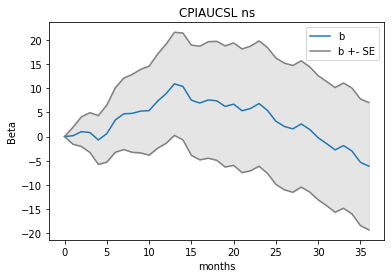

C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                            OLS Regression Results                            
Dep. Variable:             TEMP_diff0   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 07 Nov 2022   Prob (F-statistic):                nan
Time:                        21:50:35   Log-Likelihood:                    inf
No. Observations:                 273   AIC:                              -inf
Df Residuals:                     271   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0          0        nan        n

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff12   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.231
Date:                Mon, 07 Nov 2022   Prob (F-statistic):             0.0734
Time:                        21:50:35   Log-Likelihood:                -794.29
No. Observations:                 273   AIC:                             1593.
Df Residuals:                     271   BIC:                             1600.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6232      0.270      2.311      0.0

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff24   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.661
Date:                Mon, 07 Nov 2022   Prob (F-statistic):             0.0567
Time:                        21:50:36   Log-Likelihood:                -875.90
No. Observations:                 273   AIC:                             1756.
Df Residuals:                     271   BIC:                             1763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2135      0.364      3.337      0.0

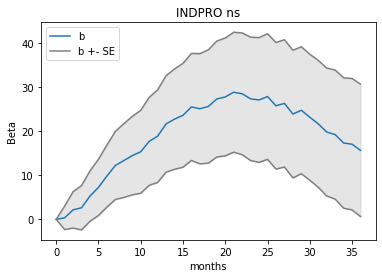

C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                            OLS Regression Results                            
Dep. Variable:             TEMP_diff0   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 07 Nov 2022   Prob (F-statistic):                nan
Time:                        21:50:36   Log-Likelihood:                    inf
No. Observations:                 273   AIC:                              -inf
Df Residuals:                     271   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0          0        nan        n

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff14   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.087
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.150
Time:                        21:50:36   Log-Likelihood:                -570.65
No. Observations:                 273   AIC:                             1145.
Df Residuals:                     271   BIC:                             1153.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0143      0.119     -0.120      0.9

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff27   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.482
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.225
Time:                        21:50:37   Log-Likelihood:                -626.06
No. Observations:                 273   AIC:                             1256.
Df Residuals:                     271   BIC:                             1263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0930      0.146      0.639      0.5

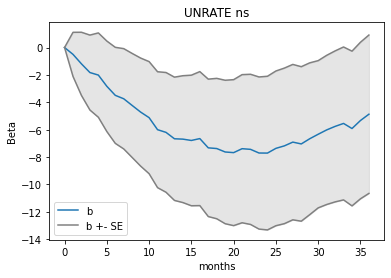

C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                            OLS Regression Results                            
Dep. Variable:             TEMP_diff0   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 07 Nov 2022   Prob (F-statistic):                nan
Time:                        21:50:37   Log-Likelihood:                    inf
No. Observations:                 273   AIC:                              -inf
Df Residuals:                     271   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0          0        nan        n

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff14   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.070
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.302
Time:                        21:50:37   Log-Likelihood:                -3140.1
No. Observations:                 273   AIC:                             6284.
Df Residuals:                     271   BIC:                             6291.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.779e+04   1454.196     12.231      0.0

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff29   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9645
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.327
Time:                        21:50:37   Log-Likelihood:                -3228.7
No. Observations:                 273   AIC:                             6461.
Df Residuals:                     271   BIC:                             6469.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.402e+04   2011.845     16.911      0.0

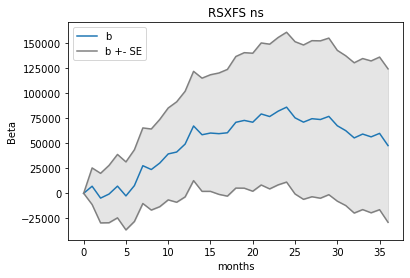

C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1827: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:926: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\ianda\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


                            OLS Regression Results                            
Dep. Variable:             TEMP_diff0   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 07 Nov 2022   Prob (F-statistic):                nan
Time:                        21:50:38   Log-Likelihood:                    inf
No. Observations:                 272   AIC:                              -inf
Df Residuals:                     270   BIC:                              -inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0          0        nan        n

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff13   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2560
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.613
Time:                        21:50:38   Log-Likelihood:                -2431.2
No. Observations:                 272   AIC:                             4866.
Df Residuals:                     270   BIC:                             4874.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1715.8824    112.185     15.295      0.0

                            OLS Regression Results                            
Dep. Variable:            TEMP_diff27   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.08029
Date:                Mon, 07 Nov 2022   Prob (F-statistic):              0.777
Time:                        21:50:38   Log-Likelihood:                -2476.1
No. Observations:                 272   AIC:                             4956.
Df Residuals:                     270   BIC:                             4963.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3357.2353    132.289     25.378      0.0

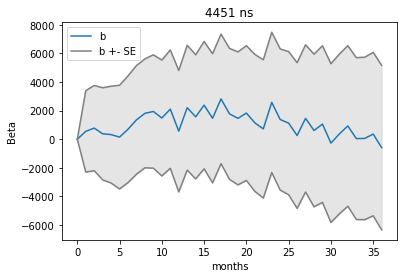

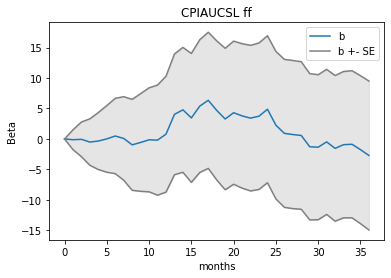

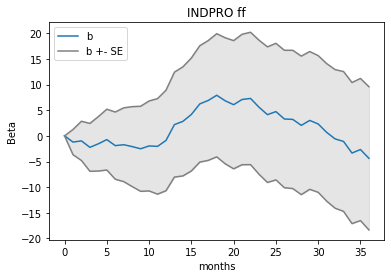

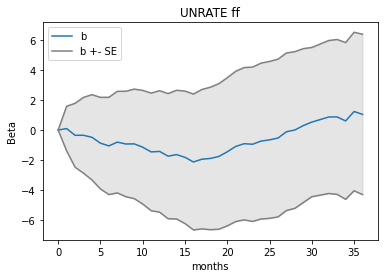

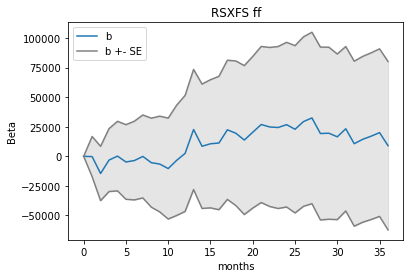

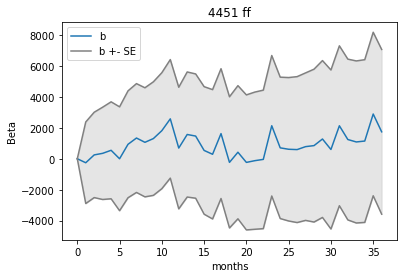

In [27]:
# OUTPUTTING ALL TABLES

# for choosing which shock you want to run regression against select 1 for ns and 2 for ff
# i.e. create_line_plot(final_df, 36, 'CPIAUCSL', 1) for ns
#      create_line_plot(final_df, 36, 'CPIAUCSL', 2) for ff

create_line_plot(final_df, 36, 'CPIAUCSL', 1)
create_line_plot(final_df, 36, 'INDPRO', 1)
create_line_plot(final_df, 36, 'UNRATE', 1)
create_line_plot(final_df, 36, 'RSXFS', 1)
create_line_plot(final_df, 36, '4451', 1) 

create_line_plot(final_df, 36, 'CPIAUCSL', 2)
create_line_plot(final_df, 36, 'INDPRO', 2)
create_line_plot(final_df, 36, 'UNRATE', 2)
create_line_plot(final_df, 36, 'RSXFS', 2)
create_line_plot(final_df, 36, '4451', 2)


# total retail sales (RSXFS)
# grocery stores retail sales (4451)